## Setup and data loading

In [1]:
#Required Imports
import numpy as np
import tensorflow as tf  # For tf.data
import matplotlib.pyplot as plt
import keras
from keras import layers

2024-08-16 08:35:48.554786: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 08:35:48.554920: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 08:35:48.681912: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
import random

#UTILS

def shuffle_and_combine_arrays(array1, array2, array3):
  combined_array = array1 + array2 + array3
  random.shuffle(combined_array)
  return combined_array

def create_tuples(array, num):
  tuples = [(element, num) for element in array]
  return tuples

def create_train_test_split(folder_path,num, train_ratio=0.8, test_ratio=0.1):
  # Get a list of all files in the folder
  files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)]
  random.shuffle(files)

  # Calculate the number of files for each set
  num_files = len(files)
  num_train = int(num_files * train_ratio)
  num_test = int(num_files * test_ratio)
  num_validation = num_files - num_train - num_test

  # Create the three lists
  train_files = files[:num_train]
  validation_files = files[num_train:num_train + num_validation]
  test_files = files[num_train + num_validation:]

  return create_tuples(train_files,num), create_tuples(validation_files,num) , create_tuples(test_files,num)


In [3]:
neg_tr, neg_val, neg_test = create_train_test_split("/kaggle/input/sentiment-data/final_proc/negative","0", train_ratio=0.8, test_ratio=0.1)
neu_tr, neu_val, neu_test = create_train_test_split("/kaggle/input/sentiment-data/final_proc/neutral","1", train_ratio=0.8, test_ratio=0.1)
pos_tr, pos_val, pos_test = create_train_test_split("//kaggle/input/sentiment-data/final_proc/positive","2", train_ratio=0.8, test_ratio=0.1)

trainl = shuffle_and_combine_arrays(neg_tr, neu_tr, pos_tr)
vall = shuffle_and_combine_arrays(neg_val, neu_val, pos_val)
testl = shuffle_and_combine_arrays(neg_test, neu_test, pos_test)

trainX = [f[0] for f in trainl]
trainY = [f[1] for f in trainl]
valX = [f[0] for f in vall]
valY = [f[1] for f in vall]
testX = [f[0] for f in testl]
testY = [f[1] for f in testl]

ds_train_X = tf.data.Dataset.from_tensor_slices(trainX)
ds_test_X = tf.data.Dataset.from_tensor_slices(testX)
ds_val_X = tf.data.Dataset.from_tensor_slices(valX)
ds_train_Y = tf.data.Dataset.from_tensor_slices(trainY)
ds_test_Y = tf.data.Dataset.from_tensor_slices(testY)
ds_val_Y = tf.data.Dataset.from_tensor_slices(valY)

ds_train = tf.data.Dataset.zip((ds_train_X,ds_train_Y))
ds_val = tf.data.Dataset.zip((ds_val_X,ds_val_Y))
ds_test = tf.data.Dataset.zip((ds_test_X,ds_test_Y))

In [4]:
#Image augmentation. The function defined below is later mapped to the tf dataset.
img_augmentation_layers = [
    layers.RandomRotation(factor=0.05),
#     layers.RandomTranslation(height_factor=0.02, width_factor=0.02),
#     layers.RandomZoom(0.05, 0.05),
    layers.RandomContrast(factor=0.05),
    layers.RandomBrightness(factor = 0.05),
]

def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

In [5]:
for i in ds_train:
    z = i
    break

In [6]:
z[1]

<tf.Tensor: shape=(), dtype=string, numpy=b'1'>

In [7]:
# Mapping preprocessing functions to datasets.

def input_preprocess_train(image, label):
    image = tf.io.read_file(image)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    label = int(label)
    label = tf.one_hot(label, 3)
    image = img_augmentation(image)
    return image, label

def input_preprocess_test(image, label):
    image = tf.io.read_file(image)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    label = int(label)
    label = tf.one_hot(label, 3)
    return image, label


ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

(224, 224, 3)
Label:  tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)


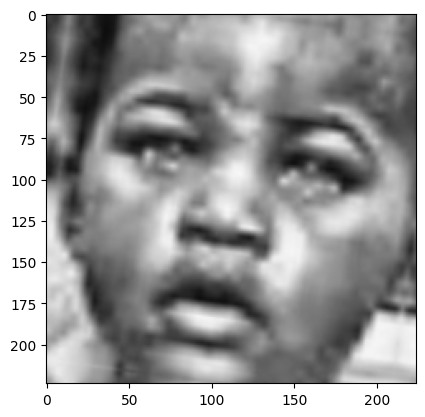

In [8]:
#Sample Image with corresponding one-hot encoded vector
for i in ds_train:
    z = i
    break
print(z[0].shape)
print("Label: ",z[1])
plt.imshow(np.array(z[0]).astype(np.uint8))

## Model training and fine-tuning

We take the Efficientnetv2-b1 model for this task, and fine-tune it using weights from the imagenet dataset.
The training will take place in 2 steps. First we will freeze all layers except the last layer, and only train on it. Once that reaches saturation, the last 15 layers are un-freezed, and further improvement in the model is seen.

In [9]:
def build_model(num_classes):
    inputs = layers.Input(shape=(224, 224, 3))
    
    model = keras.applications.EfficientNetV2B1(
    include_top=False,
    weights="imagenet",
    input_tensor=inputs,
    include_preprocessing=True,
    name="efficientnetv2-b1",
    )
    
#     Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="Enetv2b1")
    return model

#Initiliaze model.
#3 classes, negative, neutral, positive
model = build_model(num_classes=3)

28456008/28456008 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
#General callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}.weights.h5.keras".format('efv2b1_new2_onlytop')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = False)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                   patience=5,
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-8)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=10)
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [11]:
BATCH_SIZE = 64
ds_train = ds_train.shuffle(buffer_size=1000)  # Shuffle dataset for better training
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(buffer_size=tf.data.AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE)

In [12]:
# #Compiling and training last layer of model.
# #We use Adam optimizer with a relatively high learning rate initially. Callbacks reduce it automatically
optimizer = keras.optimizers.Adam(learning_rate=3e-5)    
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
hist1 = model.fit(ds_train, epochs=20, validation_data=ds_val, callbacks = callbacks_list)

Epoch 1/20
  2/356 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.4102 - loss: 1.3091   

I0000 00:00:1723797437.748875      66 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.3545 - loss: 1.5888
Epoch 1: val_loss improved from inf to 1.16893, saving model to efv2b1_new2_onlytop.weights.h5.keras
356/356 ━━━━━━━━━━━━━━━━━━━━ 231s 449ms/step - accuracy: 0.3546 - loss: 1.5886 - val_accuracy: 0.4086 - val_loss: 1.1689 - learning_rate: 3.0000e-05
Epoch 2/20
355/356 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.4080 - loss: 1.3812
Epoch 2: val_loss improved from 1.16893 to 1.15130, saving model to efv2b1_new2_onlytop.weights.h5.keras
356/356 ━━━━━━━━━━━━━━━━━━━━ 83s 226ms/step - accuracy: 0.4080 - loss: 1.3810 - val_accuracy: 0.4550 - val_loss: 1.1513 - learning_rate: 3.0000e-05
Epoch 3/20
355/356 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.4379 - loss: 1.2862
Epoch 3: val_loss improved from 1.15130 to 1.09224, saving model to efv2b1_new2_onlytop.weights.h5.keras
356/356 ━━━━━━━━━━━━━━━━━━━━ 85s 231ms/step - accuracy: 0.4379 - loss: 1.2861 - val_accuracy: 0.4923 - val_loss: 1.0922 - learning_rate: 3.

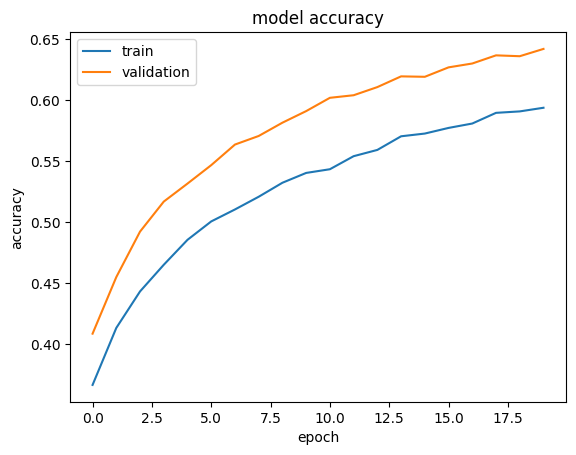

In [13]:
#Plotting curve
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist1)

In [14]:
model.load_weights("/kaggle/working/efv2b1_new2_onlytop.weights.h5.keras")

In [15]:
Xtest = []
Ytest = []
for i in ds_test:
    x,y = i
    Xtest.append(x)
    Ytest.append(y)

In [16]:
#Evaluating on test dataset
model.evaluate(np.array(Xtest), np.array(Ytest))

89/89 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.6274 - loss: 0.8400


[0.8363574147224426, 0.6224489808082581]

In [17]:
#We unfreeze more layers for better training. This pattern of unfreezing layers gradually performs better than directly unfreezing the whole model in one go.

def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=7e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

In [18]:
#Configuring and Training for next part
#We will first define checkpoint callback again (as file name is different)
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path="{}.weights.h5.keras".format('efv2b1_new2_unfreezed')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = False)

callbacks_list = [checkpoint, early, reduceLROnPlat]

In [19]:
optimizer = keras.optimizers.Adam(learning_rate=7e-4)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
hist2 = model.fit(ds_train, epochs=40, validation_data=ds_val, callbacks = callbacks_list)

Epoch 1/40
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.6356 - loss: 0.8395
Epoch 1: val_loss improved from inf to 0.67584, saving model to efv2b1_new2_unfreezed.weights.h5.keras
356/356 ━━━━━━━━━━━━━━━━━━━━ 203s 387ms/step - accuracy: 0.6357 - loss: 0.8394 - val_accuracy: 0.7106 - val_loss: 0.6758 - learning_rate: 7.0000e-04
Epoch 2/40
355/356 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7285 - loss: 0.6501
Epoch 2: val_loss improved from 0.67584 to 0.56101, saving model to efv2b1_new2_unfreezed.weights.h5.keras
356/356 ━━━━━━━━━━━━━━━━━━━━ 83s 227ms/step - accuracy: 0.7285 - loss: 0.6500 - val_accuracy: 0.7672 - val_loss: 0.5610 - learning_rate: 7.0000e-04
Epoch 3/40
355/356 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.7441 - loss: 0.6070
Epoch 3: val_loss improved from 0.56101 to 0.54616, saving model to efv2b1_new2_unfreezed.weights.h5.keras
356/356 ━━━━━━━━━━━━━━━━━━━━ 85s 232ms/step - accuracy: 0.7441 - loss: 0.6069 - val_accuracy: 0.7729 - val_loss: 0.5462 - 

In [20]:
model.load_weights("/kaggle/working/efv2b1_new2_unfreezed.weights.h5.keras")

In [21]:
#Evaluating on test dataset
model.evaluate(np.array(Xtest), np.array(Ytest))

89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.8077 - loss: 0.4942


[0.4886646866798401, 0.8145672082901001]

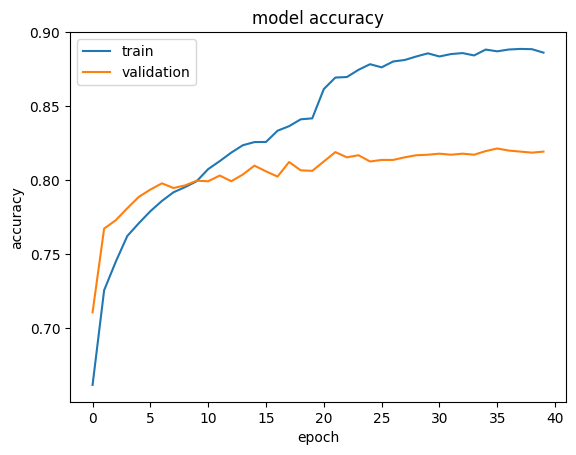

In [22]:
plot_hist(hist2)

In [23]:
#Testing on some custom images was also done. here is an example of an image of my friend

In [24]:
#UTILS

from skimage import exposure
import cv2
import numpy as np
import tensorflow as tf
import os
from PIL import Image
import matplotlib.pyplot as plt

face_cascade = cv2.CascadeClassifier('/kaggle/input/testpics/haarcascade_frontalface_alt.xml')

def enhance_contrast(image_array):
    image_array = image_array.astype(np.float32) / 255.0
    image_array_eq = exposure.equalize_hist(image_array)
    return (image_array_eq * 255).astype(np.uint8)

def adaptive_hist_eq(image_array):
    try:
        image_array = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    except:
        image_array = image_array
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(image_array)
    out = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)
    print(out.shape)
    return out  # Convert back to RGB

def preprocess_image(image):
    image = enhance_contrast(image).astype(np.uint8)
    image = adaptive_hist_eq(image).astype(np.float32)
    image = tf.image.resize(image,(224,224))
    image = np.array(image)
    return image


def cropper(frame):
    try:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    except:
        gray = frame
    try:
        detected_faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(5, 5))
        for (x, y, w, h) in detected_faces:
            face = frame[y:y+h, x:x+w]
        return face
    except:
        return frame

In [25]:
img = plt.imread("/kaggle/input/testpics/frame_screenshot_16.08.2024_1.png")

processed_img = preprocess_image(cropper(img))


(224, 224, 3)


/opt/conda/lib/python3.10/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


In [26]:
processed_img.shape

(224, 224, 3)

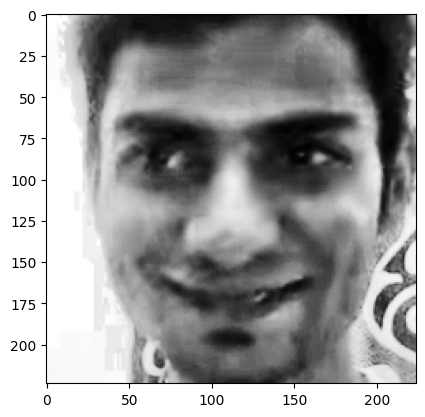

In [27]:
plt.imshow(img)

In [28]:
model.predict(np.array([processed_img]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


array([[0.0013804 , 0.01866182, 0.97995776]], dtype=float32)